Fresnel number F: How much will the beam bend at an aperture 
$F=\frac{a^2}{d*\lambda}$

Fresnel diffraction is when $F \approx1 $

Fraunhofer diffraction is when $F \ll 1$


######source beam ---distance = 196--- rectangular aperture ---distance = --- plot of beam ---distance = --- first offset mirror ---distance = 4m--- plot of beam ---distance = --- plot of beam --- distance = --- plot of beam

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#### Import modules


#Importing necessary modules:
import os
import sys
#sys.path.insert(0,os.path.join('..','..'))
sys.path.insert(0,'/home/meyerann/WPG')

import time
import copy
import numpy
import pylab


#import SRW core functions
from wpg.srwlib import srwl,SRWLOptD,SRWLOptA,SRWLOptC,SRWLOptT,SRWLOptL,SRWLOptMirEl

#import SRW helpers functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import plot_1d, plot_2d, calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh
#Import base wavefront class
from wpg import Wavefront

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy

pylab.ion()

#### Defining auxiliary function

In [3]:
def calculate_source_fwhm(ekev, theta_fwhm):
    """
    Calculate source size from photon energy and FWHM angular divergence
    
    :param evev: Energy in keV
    :param theta_fwhm: theta_fwhm [units?] 
    :return: sigma0*k [AKM]
    """
    wl = 12.39e-10/ekev
    k = 2 * sqrt(2*log(2))
    theta_sigma = theta_fwhm /k
    sigma0 = wl /(2*numpy.pi*theta_sigma)
    return sigma0*k

In [4]:
def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011
    
    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

#### Defining initial wavefront with an energz of 0.8keV and an e-bunch charge of 0.1nC. Afterwards writing electric field data to h5-file

*****defining initial wavefront and writing electric field data to h5-file...
waist_fwhm [um], theta_fwhms [urad]: 37.2822729018 18.3457259238
[nx, ny, xmin, xmax, ymin, ymax] [400, 400, -0.0038174491174569917, 0.0038174491174569917, -0.0038174491174569917, 0.0038174491174569917]


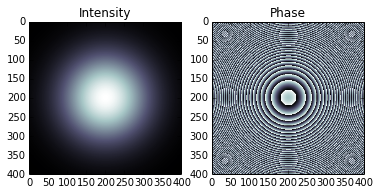

FWHMx [mm]: 3.57826057626
FWHMy [mm]: 3.57826057626
Coordinates of center, [mm]: 0.00956754164776 0.00956754164776
stepX, stepY [um]: 19.1350832955 19.1350832955 

Total power (integrated over full range): 43.1071 [GW]
Peak power calculated using FWHM:         43.9333 [GW]
Max irradiance: 3.01583 [GW/mm^2]
[nx, ny, xmin, xmax, ymin, ymax] [400, 400, -0.0038174491174569917, 0.0038174491174569917, -0.0038174491174569917, 0.0038174491174569917]
FWHMx [mm], theta_fwhm [urad]: 3.57826057626 18.2564315115


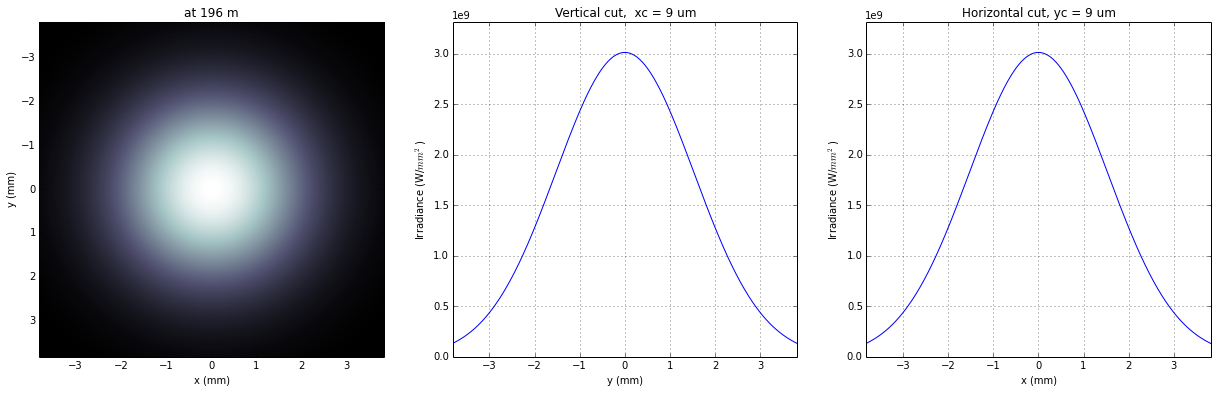

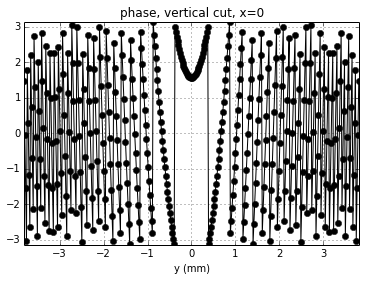

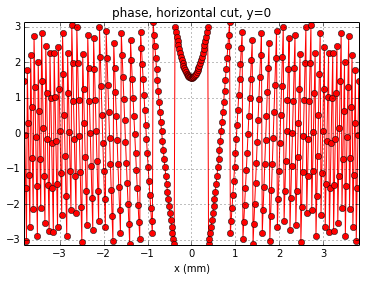

In [5]:
#**********************Input Wavefront Structure and Parameters
print('*****defining initial wavefront and writing electric field data to h5-file...')
strInputDataFolder = 'data_common'  # input data sub-folder name
strOutputDataFolder = 'Tutorial_case_2'  # output data sub-folder name

#defining parameters for initial gaussian wavefront
qnC = 0.1                    # e-bunch charge, [nC]
pulse_duration = 9.e-15      # [AKM] [s]      
ekev = 0.8            # [AKM] Energy in [keV]
pulseEnergy = 1.e-3   # [AKM] pulse Energy in [keV] 
coh_time = 0.82e-15

#calculate angular divergence
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*sqrt(2*log(2))
sigX = 12.4e-10*k/(ekev*4*pi*theta_fwhm) 
d2Apertur = 196 # Distance to aperture [m]
d2imager0 = 275 # Distance to first imager [m]
print 'waist_fwhm [um], theta_fwhms [urad]:', sigX*k*1e6, theta_fwhm*1e6
#define limits of number of data points/picture pixel per axis[AKM] 
range_xy = theta_fwhm/k*d2Apertur*5. # sigma*4 beam size
np=400 #number of data points



#build SRW gauusian wavefront with defined parameters 
wfr0 = build_gauss_wavefront_xy(np,np,ekev,-range_xy/2,range_xy/2,-range_xy/2,range_xy/2,sigX,sigX,d2Apertur,
                                pulseEn=pulseEnergy,pulseTau=coh_time/sqrt(2),repRate=1/(sqrt(2)*pulse_duration)) 

#init WPG Wavefront helper class
mwf = Wavefront(wfr0)
#defining name HDF5 file for storing wavefront
ifname = os.path.join(strOutputDataFolder,'gwf_AKM'+'.h5')
#store wavefront to HDF5 file 
mwf.store_hdf5(ifname)
print '[nx, ny, xmin, xmax, ymin, ymax]', get_mesh(mwf)
pylab.set_cmap('bone')
plt.subplot(1,2,1)
plt.title('Intensity')
plt.imshow(mwf.get_intensity(slice_number=0))
plt.subplot(1,2,2)
plt.title('Phase')
plt.imshow(mwf.get_phase(slice_number=0,polarization='horizontal'))
plt.show()

#[AKM] draw wavefront with cuts. Plots the intensity profile of wavefront at distance of the first mirror in SASE3
plot_wfront(mwf, title_fig='at '+str(d2Apertur)+' m',
            isHlog=False, isVlog=False,
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True, bPlotPha=True)
print '[nx, ny, xmin, xmax, ymin, ymax]', get_mesh(mwf)
pylab.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
fwhm_x = calculate_fwhm_x(mwf)
print 'FWHMx [mm], theta_fwhm [urad]:',fwhm_x*1e3,fwhm_x/d2Apertur*1e6

Fraunhofer diffraction

example with $F=0.1$ and distance to screen 204m

wavelength: 1.55 nm
aperture size: 0.18 mm
fresnel number : 0.1
aperture-screen distance : 204
*****Ideal aperture without distortion
*****setting-up optical elements, beamline: blA_0.9mm
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.000177820133843
	Dy = 0.000177820133843
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.01, 2.4, 1.01, 0, 0, 0]
	L = 79
	treat = 0
	

*****reading wavefront from h5 file...
*****propagating wavefront (with resizing)...
[nx, ny, xmin, xmax, ymin, ymax] [972, 972, -0.010553918244861, 0.010532202363698734, -0.010553918244861, 0.010532202363698734]
done
*****Ideal mirror: HOM as an aperture
plot wavefront after aperture in distance [m] 79
FWHMx [mm]: 0.521181147894
FWHMy [mm]: 0.521181147894
Coordinates of center, [mm]: 0.0217158811623 0.0217158811623
stepX, stepY [um]: 21.7158811623 21.7158811623 

Total power (integrated over ful

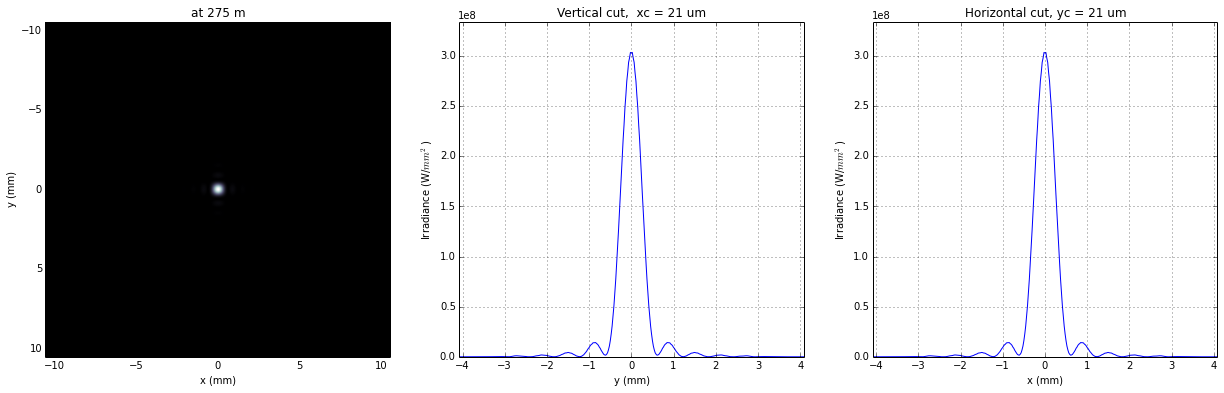

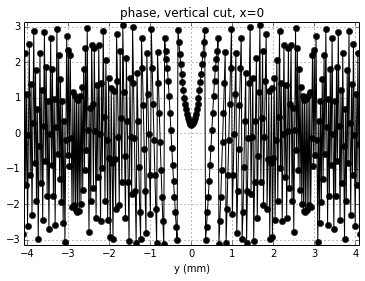

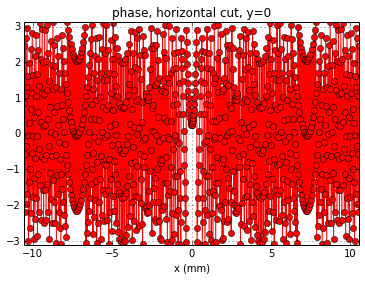

In [6]:
wl = (12.4/ekev)*1e-10 #[AKM] wavelength in [m]
F = 0.1 #[AKM] Fresnel number for Fraunhofer diffraction
d =204 #[AKM] distance between aperture and screen [m]
aS = sqrt(F*d*wl)

print 'wavelength: %.2f nm' %(wl*1e9)
print 'aperture size: %.2f mm' %(aS*1e3)
print 'fresnel number :',F
print 'aperture-screen distance :',d

d2screen = 400 # [m]
dAperture2NextElement = d2imager0 - d2Apertur
DriftA_NE = SRWLOptD(dAperture2NextElement)
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                 [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
ppApertur =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftA_NE =     [ 0,  0, 1.0,  1,  0, 2.4, 1.01, 2.4, 1.01,  0,  0,   0]
print '*****Ideal aperture without distortion'
bPlotted = False
isHlog = False
isVlog = False
bSaved = True
opApertur = SRWLOptA('r', 'a',aS, aS)  # clear aperture of the Offset Mirror(s)
strBL = 'blA_0.9mm'
print '*****setting-up optical elements, beamline:', strBL
#[AKM] optical beamline 0
optBL = SRWLOptC([opApertur, DriftA_NE],[ppApertur,ppDriftA_NE]) 
print_beamline(optBL)

print '*****reading wavefront from h5 file...'
w2 = Wavefront()
w2.load_hdf5(ifname)
wfr = w2._srwl_wf
print '*****propagating wavefront (with resizing)...'
srwl.PropagElecField(wfr, optBL)
mwf = Wavefront(wfr)
print '[nx, ny, xmin, xmax, ymin, ymax]', get_mesh(mwf)
print 'done'

print '*****Ideal mirror: HOM as an aperture'
print 'plot wavefront after aperture in distance [m]', d2imager0 - d2Apertur

#Imager 0 at point 275m (79m after the the Aperture)
#Plots the wavefront at this point.
plot_wfront(mwf, title_fig='at '+str(d2imager0)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True, bPlotPha=True)
pylab.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
pylab.axis('tight')    
#pylab.xlim(-10,10)
print '*****safing wavefront to h5 file...'
mwf.store_hdf5(ifname)
#print 'FWHMx [mm], theta_fwhm [urad]:',calculate_fwhm_x(mwf)*1e3,calculate_fwhm_x(mwf)/(dAperture2NextElement)*1e6
#print 'FWHMy [mm], theta_fwhm [urad]:',calculate_fwhm_y(mwf)*1e3,calculate_fwhm_y(mwf)/(dAperture2NextElement)*1e6

First offset mirror at point 281 (6m after imager 0) and plot the beam at position of imager 1 at point 286 (5m after offset mirror)

In [7]:
d2m1= 281


example with $F=3$ 

*****defining initial wavefront and writing electric field data to h5-file...
waist_fwhm [um], theta_fwhms [urad]: 37.2822729018 18.3457259238
[nx, ny, xmin, xmax, ymin, ymax] [400, 400, -0.0038174491174569917, 0.0038174491174569917, -0.0038174491174569917, 0.0038174491174569917]


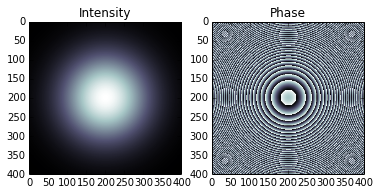

FWHMx [mm]: 3.57826057626
FWHMy [mm]: 3.57826057626
Coordinates of center, [mm]: 0.00956754164776 0.00956754164776
stepX, stepY [um]: 19.1350832955 19.1350832955 

Total power (integrated over full range): 43.1071 [GW]
Peak power calculated using FWHM:         43.9333 [GW]
Max irradiance: 3.01583 [GW/mm^2]
[nx, ny, xmin, xmax, ymin, ymax] [400, 400, -0.0038174491174569917, 0.0038174491174569917, -0.0038174491174569917, 0.0038174491174569917]
FWHMx [mm], theta_fwhm [urad]: 3.57826057626 18.2564315115


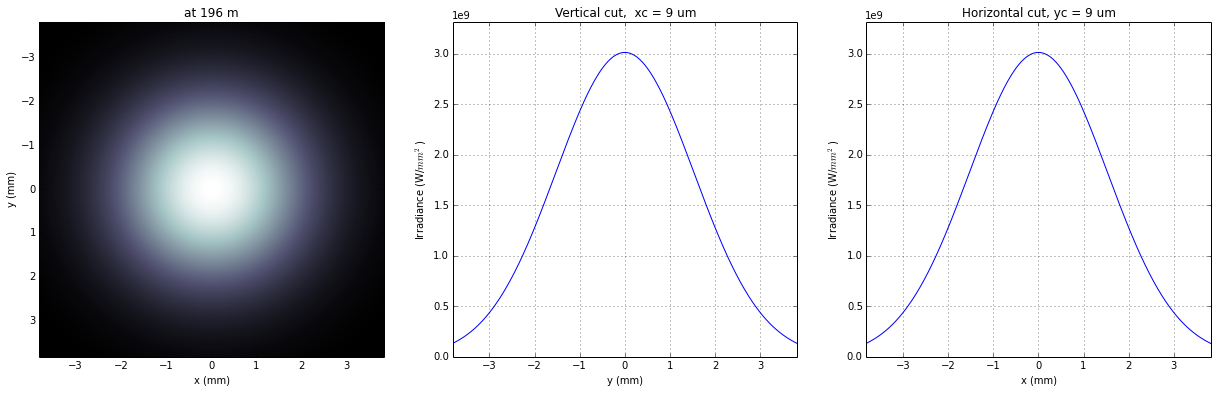

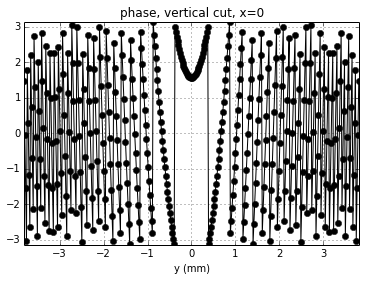

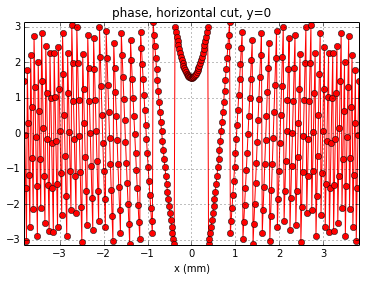

In [8]:
#**********************Input Wavefront Structure and Parameters
print('*****defining initial wavefront and writing electric field data to h5-file...')
strInputDataFolder = 'data_common'  # input data sub-folder name
strOutputDataFolder = 'Tutorial_case_2'  # output data sub-folder name

#defining parameters for initial gaussian wavefront
qnC = 0.1                    # e-bunch charge, [nC]
pulse_duration = 9.e-15      # [AKM] [s]      
ekev = 0.8            # [AKM] Energy in [keV]
pulseEnergy = 1.e-3   # [AKM] pulse Energy in [keV] 
coh_time = 0.82e-15

#calculate angular divergence
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*sqrt(2*log(2))
sigX = 12.4e-10*k/(ekev*4*pi*theta_fwhm) 
d2Apertur = 196 # Distance to aperture [m]
d2imager0 = 275 # Distance to first imager [m]
print 'waist_fwhm [um], theta_fwhms [urad]:', sigX*k*1e6, theta_fwhm*1e6
#define limits of number of data points/picture pixel per axis[AKM] 
range_xy = theta_fwhm/k*d2Apertur*5. # sigma*4 beam size
np=400 #number of data points



#build SRW gauusian wavefront with defined parameters 
wfr0 = build_gauss_wavefront_xy(np,np,ekev,-range_xy/2,range_xy/2,-range_xy/2,range_xy/2,sigX,sigX,d2Apertur,
                                pulseEn=pulseEnergy,pulseTau=coh_time/sqrt(2),repRate=1/(sqrt(2)*pulse_duration)) 

#init WPG Wavefront helper class
mwf = Wavefront(wfr0)
#defining name HDF5 file for storing wavefront
ifname = os.path.join(strOutputDataFolder,'gwf_AKM'+'.h5')
#store wavefront to HDF5 file 
mwf.store_hdf5(ifname)
print '[nx, ny, xmin, xmax, ymin, ymax]', get_mesh(mwf)
pylab.set_cmap('bone')
plt.subplot(1,2,1)
plt.title('Intensity')
plt.imshow(mwf.get_intensity(slice_number=0))
plt.subplot(1,2,2)
plt.title('Phase')
plt.imshow(mwf.get_phase(slice_number=0,polarization='horizontal'))
plt.show()

#[AKM] draw wavefront with cuts. Plots the intensity profile of wavefront at distance of the first mirror in SASE3
plot_wfront(mwf, title_fig='at '+str(d2Apertur)+' m',
            isHlog=False, isVlog=False,
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True, bPlotPha=True)
print '[nx, ny, xmin, xmax, ymin, ymax]', get_mesh(mwf)
pylab.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
fwhm_x = calculate_fwhm_x(mwf)
print 'FWHMx [mm], theta_fwhm [urad]:',fwhm_x*1e3,fwhm_x/d2Apertur*1e6

wavelength: 1.55 nm
aperture size: 1.26 mm
fresnel number : 5
aperture-screen distance : 204
*****Ideal aperture without distortion
*****setting-up optical elements, beamline: blA_0.9mm
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.00125737822472
	Dy = 0.00125737822472
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.01, 2.4, 1.01, 0, 0, 0]
	L = 79
	treat = 0
	

*****reading wavefront from h5 file...
*****propagating wavefront (with resizing)...
[nx, ny, xmin, xmax, ymin, ymax] [972, 972, -0.009542892261371082, 0.009523256680586366, -0.009542892261371082, 0.009523256680586366]
done
*****Ideal mirror: HOM as an aperture
plot wavefront after aperture in distance [m] 79
FWHMx [mm]: 1.45303297807
FWHMy [mm]: 1.45303297807
Coordinates of center, [mm]: 0.490889519618 0.490889519618
stepX, stepY [um]: 19.6355807847 19.6355807847 

Total power (integrated over full 

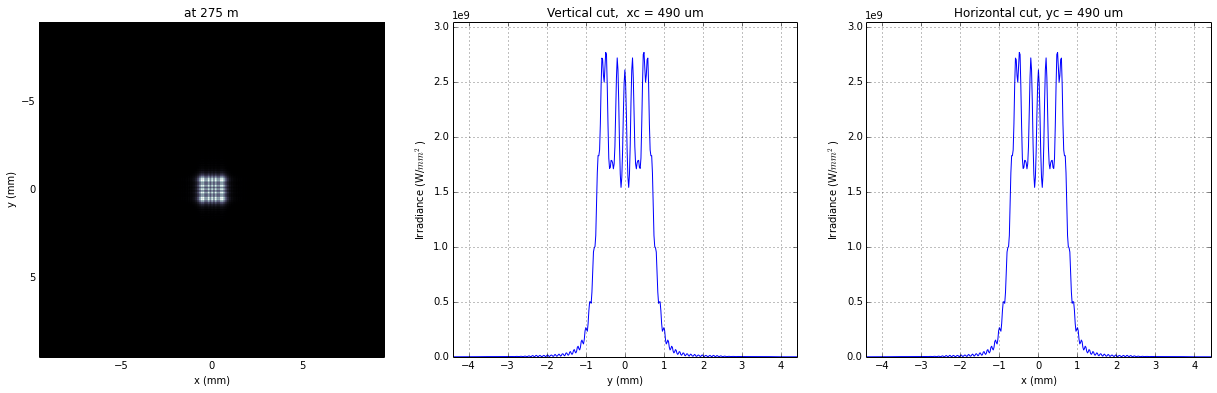

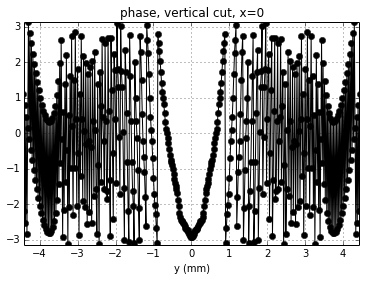

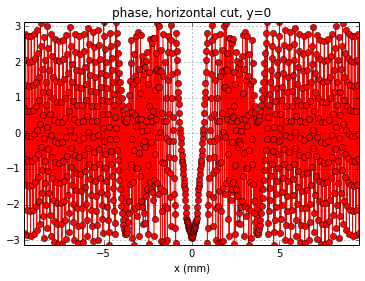

In [9]:
wl = (12.4/ekev)*1e-10 #[AKM] wavelength in [m]
F = 5 #[AKM] Fresnel number for Fraunhofer diffraction
d =204 #[AKM] distance between aperture and screen [m]
aS = sqrt(F*d*wl)

print 'wavelength: %.2f nm' %(wl*1e9)
print 'aperture size: %.2f mm' %(aS*1e3)
print 'fresnel number :',F
print 'aperture-screen distance :',d

d2screen = 400 # [m]
dAperture2NextElement = d2imager0 - d2Apertur
DriftA_NE = SRWLOptD(dAperture2NextElement)
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                 [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
ppApertur =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftA_NE =     [ 0,  0, 1.0,  1,  0, 2.4, 1.01, 2.4, 1.01,  0,  0,   0]
print '*****Ideal aperture without distortion'
bPlotted = False
isHlog = False
isVlog = False
bSaved = True
opApertur = SRWLOptA('r', 'a',aS, aS)  # clear aperture of the Offset Mirror(s)
strBL = 'blA_0.9mm'
print '*****setting-up optical elements, beamline:', strBL
#[AKM] optical beamline 0
optBL = SRWLOptC([opApertur, DriftA_NE],[ppApertur,ppDriftA_NE]) 
print_beamline(optBL)

print '*****reading wavefront from h5 file...'
w2 = Wavefront()
w2.load_hdf5(ifname)
wfr = w2._srwl_wf
print '*****propagating wavefront (with resizing)...'
srwl.PropagElecField(wfr, optBL)
mwf = Wavefront(wfr)
print '[nx, ny, xmin, xmax, ymin, ymax]', get_mesh(mwf)
print 'done'

print '*****Ideal mirror: HOM as an aperture'
print 'plot wavefront after aperture in distance [m]', d2imager0 - d2Apertur

#Imager 0 at point 275m (79m after the the Aperture)
#Plots the wavefront at this point.
plot_wfront(mwf, title_fig='at '+str(d2imager0)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True, bPlotPha=True)
pylab.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
pylab.axis('tight')    
#pylab.xlim(-10,10)
print '*****safing wavefront to h5 file...'
mwf.store_hdf5(ifname)
#print 'FWHMx [mm], theta_fwhm [urad]:',calculate_fwhm_x(mwf)*1e3,calculate_fwhm_x(mwf)/(dAperture2NextElement)*1e6
#print 'FWHMy [mm], theta_fwhm [urad]:',calculate_fwhm_y(mwf)*1e3,calculate_fwhm_y(mwf)/(dAperture2NextElement)*1e6

wavelength: 1.55 nm
aperture size: 1.26 mm
fresnel number : 5
aperture-screen distance : 204
*****Ideal aperture without distortion
*****setting-up optical elements, beamline: blA_0.9mm
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.00125737822472
	Dy = 0.00125737822472
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.01, 2.4, 1.01, 0, 0, 0]
	L = 204
	treat = 0
	

*****reading wavefront from h5 file...
*****propagating wavefront (with resizing)...
[nx, ny, xmin, xmax, ymin, ymax] [2376, 2376, -0.024411992825453, 0.02439106324771703, -0.024450757554969473, 0.024429794742363013]
done
*****Ideal mirror: HOM as an aperture
plot wavefront after aperture in distance [m] 79
FWHMx [mm]: 1.6438924151
FWHMy [mm]: 1.64650281423
Coordinates of center, [mm]: -0.53445549618 -0.51472289316
stepX, stepY [um]: 20.5486551887 20.5812851778 

Total power (integrated over full ra

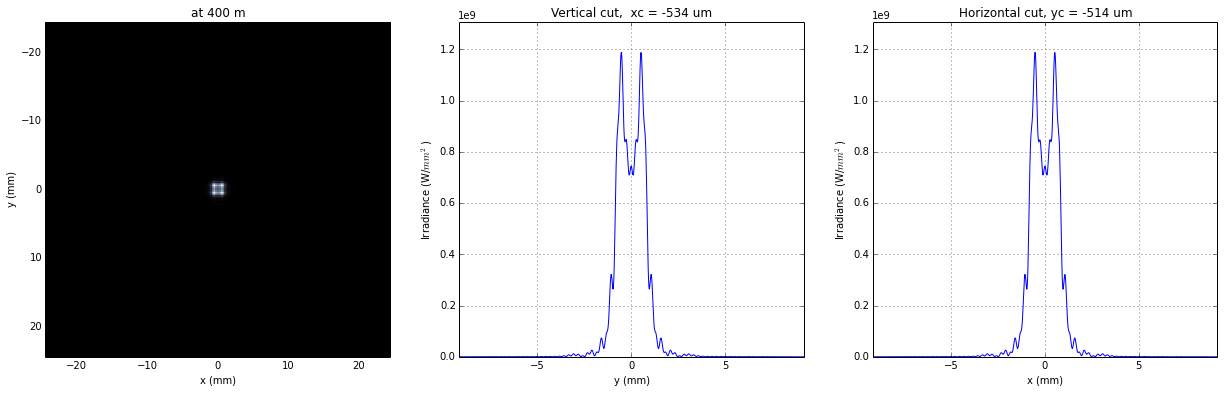

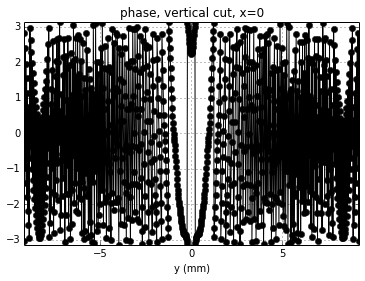

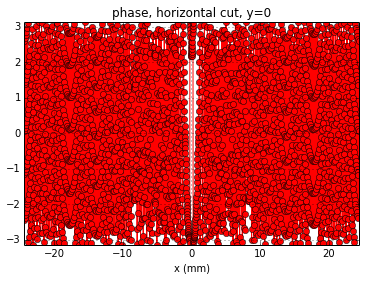

In [10]:
wl = (12.4/ekev)*1e-10 #[AKM] wavelength in [m]
F = 5 #[AKM] Fresnel number for Fraunhofer diffraction
d =204 #[AKM] distance between aperture and screen [m]
aS = sqrt(F*d*wl)

print 'wavelength: %.2f nm' %(wl*1e9)
print 'aperture size: %.2f mm' %(aS*1e3)
print 'fresnel number :',F
print 'aperture-screen distance :',d

d2Apertur = 196 # Distance to aperture [m]
d2imager0 = 275 # Distance to first imager [m]
d2screen = 400 # [m]
dAperture2NextElement = d2imager0 - d2Apertur
DriftA_NE = SRWLOptD(d)
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                 [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
ppApertur =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftA_NE =     [ 0,  0, 1.0,  1,  0, 2.4, 1.01, 2.4, 1.01,  0,  0,   0]
print '*****Ideal aperture without distortion'
bPlotted = False
isHlog = False
isVlog = False
bSaved = True
opApertur = SRWLOptA('r', 'a',aS, aS)  # clear aperture of the Offset Mirror(s)
strBL = 'blA_0.9mm'
print '*****setting-up optical elements, beamline:', strBL
#[AKM] optical beamline 0
optBL = SRWLOptC([opApertur, DriftA_NE],[ppApertur,ppDriftA_NE]) 
print_beamline(optBL)

print '*****reading wavefront from h5 file...'
w2 = Wavefront()
w2.load_hdf5(ifname)
wfr = w2._srwl_wf
print '*****propagating wavefront (with resizing)...'
srwl.PropagElecField(wfr, optBL)
mwf = Wavefront(wfr)
print '[nx, ny, xmin, xmax, ymin, ymax]', get_mesh(mwf)
print 'done'

print '*****Ideal mirror: HOM as an aperture'
print 'plot wavefront after aperture in distance [m]', d2imager0 - d2Apertur

#Imager 0 at point 275m (79m after the the Aperture)
#Plots the wavefront at this point.
plot_wfront(mwf, title_fig='at '+str(d2screen)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True, bPlotPha=True)
pylab.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
pylab.axis('tight')    
#pylab.xlim(-10,10)
print '*****safing wavefront to h5 file...'
mwf.store_hdf5(ifname)
#print 'FWHMx [mm], theta_fwhm [urad]:',calculate_fwhm_x(mwf)*1e3,calculate_fwhm_x(mwf)/(dAperture2NextElement)*1e6
#print 'FWHMy [mm], theta_fwhm [urad]:',calculate_fwhm_y(mwf)*1e3,calculate_fwhm_y(mwf)/(dAperture2NextElement)*1e6